# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

### rolling and slicing wg for `ds_tns` and `ds_vel`, and saving to cloud

### Begin nb

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

<Client: 'tls://10.8.4.8:8786' processes=30 threads=60, memory=120.00 GiB>

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [4]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
#coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) #didn't upload wg region
coords = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr'))
ds_tns = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_tns_wg.zarr'))
ds_vel = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_vel_wg.zarr'))
ds_sig_theta = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta_wg.zarr'))
ds_sig_salt = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_wg.zarr'))
ds_drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/drhodts_wg.zarr'))
empmr = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_SIempmr_wg.zarr'))
#ds_tmp_slt_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_slt_wg.zarr')) #from sigma-budget-zspace-sose.ipynb

In [7]:
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])#, empmr])
ds

<xarray.Dataset>
Dimensions:                   (XC: 570, YC: 95, Z: 42, time: 438, XG: 571, YG: 96, Zl: 42)
Coordinates:
  * XC                        (XC) float32 295.1 295.2 295.4 ... 29.75 29.92
  * YC                        (YC) float32 -77.87 -77.71 ... -62.37 -62.21
  * Z                         (Z) float32 -5.0 -15.5 ... -5.325e+03 -5.575e+03
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 295.0 295.2 295.3 ... 29.83 30.0
  * YG                        (YG) float32 -77.96 -77.79 ... -62.29 -62.12
  * Zl                        (Zl) float32 0.0 -10.0 ... -5.2e+03 -5.45e+03
Data variables: (12/22)
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    ...                        ...
    drhodt_wg                 (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 571), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 96, 570), meta=np.ndarray>
    WSLTMASS                  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WTHMASS                   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

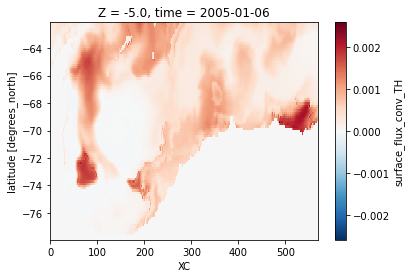

In [11]:
(ds.surface_flux_conv_TH[0,0]/1e6).drop('XC').plot()

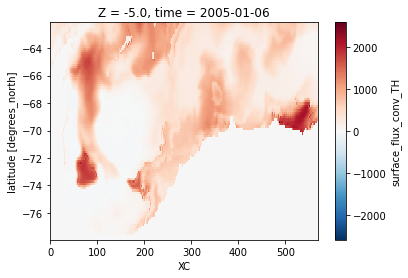

In [12]:
ds.surface_flux_conv_TH[0,0].drop('XC').plot()

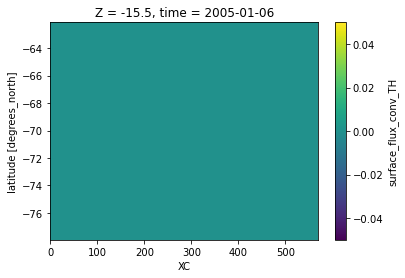

In [33]:
ds.surface_flux_conv_TH[0,1].drop('XC').plot()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


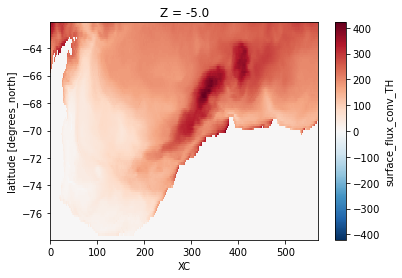

In [35]:
ds.surface_flux_conv_TH.mean(dim='time')[0].drop('XC').plot()

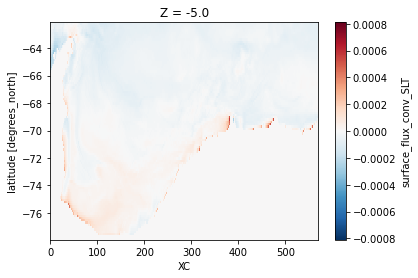

In [13]:
(ds.surface_flux_conv_SLT.mean(dim='time')/1e6)[0].drop('XC').plot()

In [14]:
ds.time

<xarray.DataArray 'time' (time: 438)>
array(['2005-01-06T00:00:00.000000000', '2005-01-11T00:00:00.000000000',
       '2005-01-16T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [9]:
pref = 2000

In [16]:
mask = ds.surface_flux_conv_SLT.where(ds.surface_flux_conv_SLT!=0)

In [17]:
mask

<xarray.DataArray 'surface_flux_conv_SLT' (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<where, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

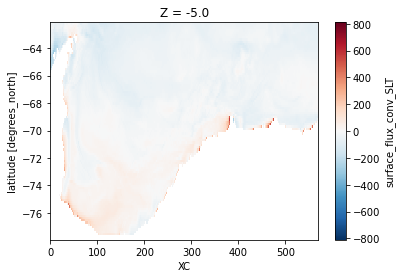

In [18]:
mask.mean(dim='time')[0].drop('XC').plot()

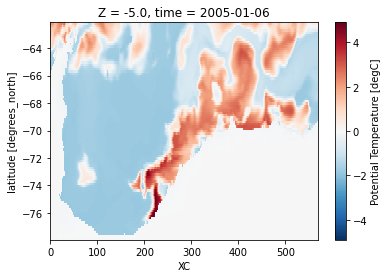

In [19]:
ds_tns.THETA[0,0].where(mask[0,0]).drop('XC').plot()

### Checking if `rhs` and `lhs` seem to match

In [20]:
ds_sig_salt.data_vars

Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [21]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [22]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<add, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

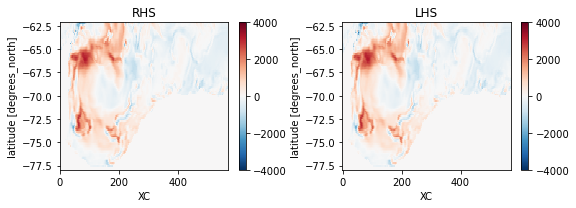

In [23]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].drop('XC').plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].drop('XC').plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [10]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT, ds_tns.THETA, pref,
                            output_dtypes=[ds_tns.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True)#.load()

In [11]:
sigma2

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<transpose, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [12]:
sigma2.nbytes/1e9

3.9845736

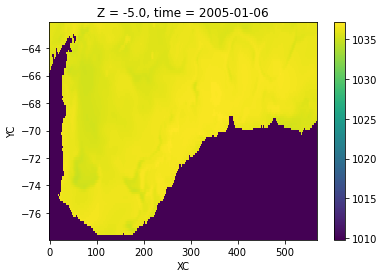

In [27]:
sigma2[0,0].drop('XC').plot()

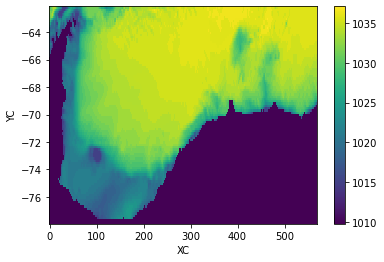

In [28]:
sigma2.mean(dim=['time', 'Z']).drop('XC').plot()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

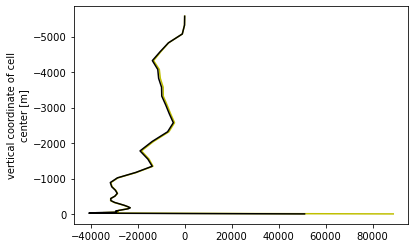

In [13]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['YC', 'XC'])/ total_time).plot(y='Z', yincrease=False, color='y')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k')

In [14]:
totend_truth = (delta_sigma * vol) / total_time

In [15]:
dt = ds.time.diff(dim='time').astype(np.float64) / 1e9

In [16]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [33]:
sigma2.diff(dim='time').coords

Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [17]:
dsig_dt = (sigma2.diff(dim='time')*vol)/dt

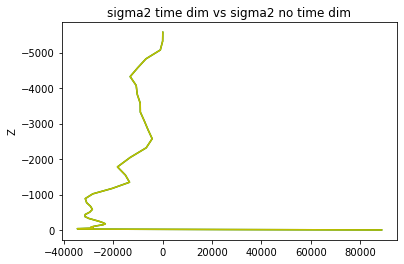

In [35]:
dsig_dt.sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='green')
totend_truth.sum(dim=['YC', 'XC']).plot(y='Z', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

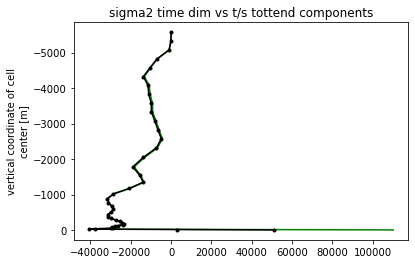

In [27]:
((sigma2.diff(dim='time')*vol)/coords.dt).mean(dim='time').sum(dim=['YC', 'XC']).plot(y='Z', yincrease=False, color='green')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

In [18]:
totend_truth = (sigma2.diff(dim='time')*vol) / dt

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

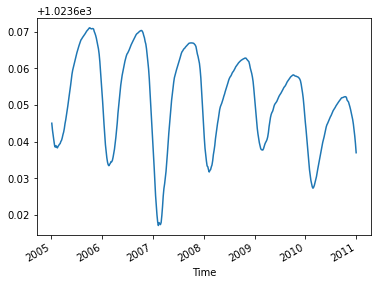

In [22]:
#looks strange but it's similar to ECCO considering the shorter time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.mean(dim=['XC', 'YC', 'Z']).plot()

In [28]:
sigma2.min().values

array(1009.78870743)

In [29]:
sigma2.max().values

array(1037.55056821)

In [30]:
sigma2.where(mask).min().values

array(1009.78870743)

In [19]:
# define bins (make same as ECCO)
delta_sigma = 3.7e-3
sigma_bins = np.arange(1036.9, 1037.27, delta_sigma)

In [20]:
sigma_bins.size

100

In [21]:
ds = ds.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})
coords = coords.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})

In [22]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['XC', 'YC', 'Z']).load()

In [23]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 99)>
array([[3.4201173e+12, 3.8215140e+12, 3.9988916e+12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.5693878e+12, 4.0005704e+12, 4.0065869e+12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.9601641e+12, 4.1608660e+12, 4.3057134e+12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.4728614e+12, 4.5962840e+12, 4.6165467e+12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.5072494e+12, 4.6234453e+12, 4.8378869e+12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.3880253e+12, 4.6723136e+12, 5.1543650e+12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

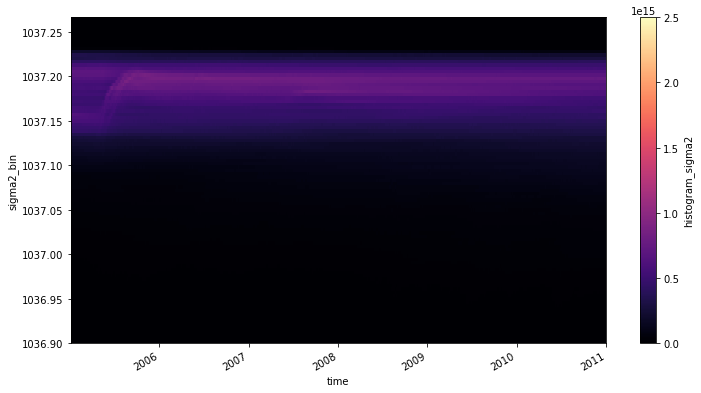

In [24]:
#most volumous water has densities up to 1037.20kg/m^3
#how to check the single-value density for most volumous?
sigma_dist.plot(x='time', figsize=(12, 6), vmax=2.5e15, cmap='magma')
#plt.ylim(1036.9, 1037.3)

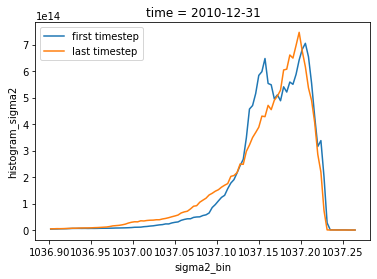

In [44]:
#waters with density up to 1037.13 got denser?
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1036.7, 1037.3);

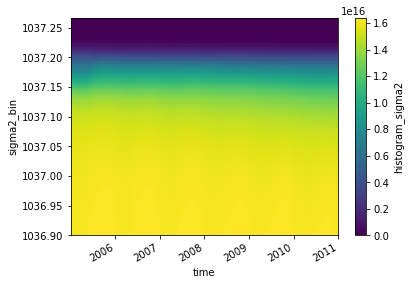

In [25]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
#plt.ylim(1037.5, 1036.4)

In [46]:
V

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 99)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6247241e+16,
        1.6251062e+16, 1.6254482e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6238573e+16,
        1.6242574e+16, 1.6246143e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6229842e+16,
        1.6234002e+16, 1.6237962e+16],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6226027e+16,
        1.6230623e+16, 1.6235097e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6213828e+16,
        1.6218451e+16, 1.6222959e+16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6203290e+16,
        1.6207962e+16, 1.6212350e+16]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

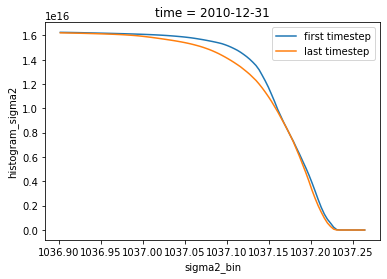

In [47]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1037.5, 1036.5)

In [26]:
delta_V = V.diff(dim='time')

In [27]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 437, sigma2_bin: 99)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.6672440e+12, -8.4879291e+12, -8.3386790e+12],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.7316685e+12, -8.5716810e+12, -8.1808390e+12],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.4700219e+12, -7.5516262e+12, -7.7169825e+12],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.3821205e+13, -1.3900662e+13, -1.3873818e+13],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.2198781e+13, -1.2171937e+13, -1.2137578e+13],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.0537702e+13, -1.0489384e+13, -1.0608569e+13]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

## $\frac{\partial \mathcal{V}}{\partial t}$

In [50]:
delta_V.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [51]:
dt.time.dtype

dtype('<M8[ns]')

In [52]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [28]:
dVdt = delta_V / dt

In [29]:
dVdt

<xarray.DataArray (time: 437, sigma2_bin: 99)>
array([[        0.        ,         0.        ,         0.        , ...,
        -20063064.82251852, -19647984.07111111, -19302497.69718518],
       [        0.        ,         0.        ,         0.        , ...,
        -20212195.63140741, -19841854.12266667, -18937127.21540741],
       [        0.        ,         0.        ,         0.        , ...,
        -17291717.29066667, -17480616.31525926, -17863385.39140741],
       ...,
       [        0.        ,         0.        ,         0.        , ...,
        -31993529.53362963, -32177457.53125926, -32115319.69422222],
       [        0.        ,         0.        ,         0.        , ...,
        -28237918.66311111, -28175780.82607407, -28096244.39466667],
       [        0.        ,         0.        ,         0.        , ...,
        -24392829.30725926, -24280981.20059259, -24556873.19703704]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

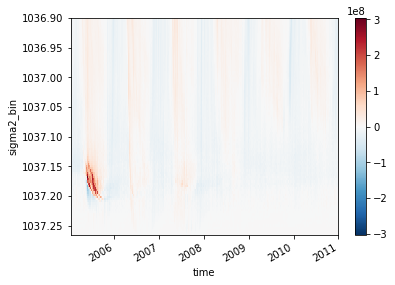

In [30]:
dVdt.plot(x='time', yincrease=False)
#plt.ylim(1035.5, 1037.3)

## $\Omega_{total}$

In [58]:
omega_total_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_TH_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (- delta_sigma)
omega_total_th.load()

omega_total_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_SLT_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (-delta_sigma)
omega_total_slt.load()

omega_total = omega_total_th + omega_total_slt
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 99)>
array([[-16070896.41538993, -21634616.76790782, -16581887.06821582, ...,
                0.        ,         0.        ,         0.        ],
       [-19344803.96359259, -19852199.75741958, -19006068.65745028, ...,
                0.        ,         0.        ,         0.        ],
       [-18661321.49217936, -16341548.64543969, -19171239.03389725, ...,
                0.        ,         0.        ,         0.        ],
       ...,
       [-28281801.88359488, -25635768.06265767, -25442308.85661236, ...,
                0.        ,         0.        ,         0.        ],
       [-34032162.50826449, -31587222.34633344, -34856529.84622905, ...,
                0.        ,         0.        ,         0.        ],
       [-17146955.55112172, -19035540.69165179, -18682201.53030717, ...,
                0.        ,         0.        ,         0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [59]:
totend_truth.coords

Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [60]:
sigma2[1:].coords

Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31

In [31]:
omega_total = - histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=totend_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (- delta_sigma)

omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 437, sigma2_bin: 99)>
array([[-16395351.02124294, -17017323.70162661, -16739732.75968824, ...,
                0.        ,         0.        ,         0.        ],
       [-17717145.83998267, -17275661.13992155, -19385145.58963717, ...,
                0.        ,         0.        ,         0.        ],
       [-12909265.44336062, -13337433.5070989 , -11215876.39961861, ...,
                0.        ,         0.        ,         0.        ],
       ...,
       [-24664381.34747806, -23002024.69231363, -24176130.8205508 , ...,
                0.        ,         0.        ,         0.        ],
       [-26477480.72399738, -25539107.29226043, -29233153.96946761, ...,
                0.        ,         0.        ,         0.        ],
       [-19403441.61073516, -19431426.45355257, -20878060.76245895, ...,
                0.        ,         0.        ,         0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

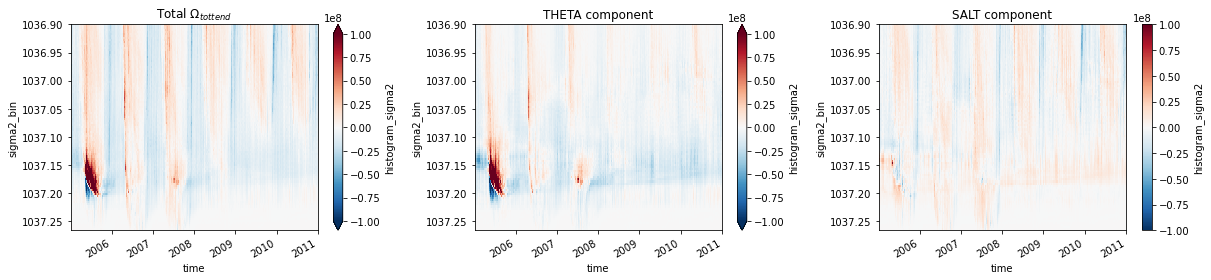

In [62]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0, yincrease=False)
#ax0.set_ylim(ymax=1037.25, ymin=1035.5)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1, yincrease=False)
#ax1.set_ylim(ymax=1037.25, ymin=1035.5)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2, yincrease=False)
#ax2.set_ylim(ymax=1037.25, ymin=1035.5)
ax2.set_title('SALT component')

plt.tight_layout();

Text(0.5, 1.0, 'Total $\\Omega_{tottend}$')

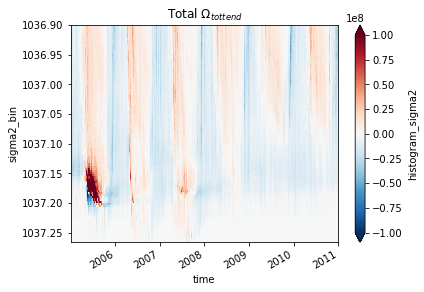

In [63]:
omega_total.plot(x='time', vmax=1e8, yincrease=False)
#plt.ylim(ymax=1037.25, ymin=1035.5)
plt.title(r'Total $\Omega_{tottend}$')

Text(0.5, 1.0, 'New Total $\\Omega_{tottend}$ from `totend_truth`')

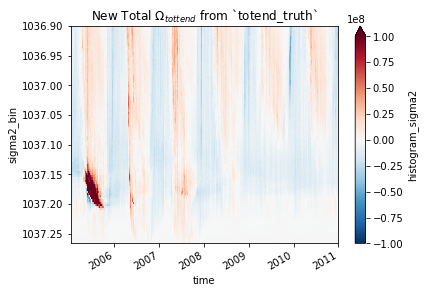

In [32]:
omega_total.plot(x='time', vmax=1e8, yincrease=False)
#plt.ylim(ymax=1037.25, ymin=1035.5)
plt.title(r'New Total $\Omega_{tottend}$ from `totend_truth`')

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

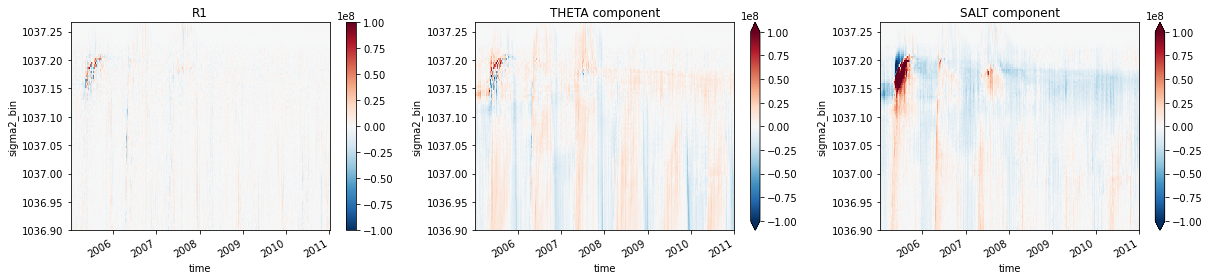

In [67]:
R1 = dVdt - omega_total
R1_th = dVdt - omega_total_th
R1_slt = dVdt - omega_total_slt

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
#ax0.set_ylim(ymax=1037.25, ymin=1035.5)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
#ax1.set_ylim(ymax=1037.25, ymin=1035.5)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
#ax2.set_ylim(ymax=1037.25, ymin=1035.5)
ax2.set_title('SALT component')

plt.tight_layout();

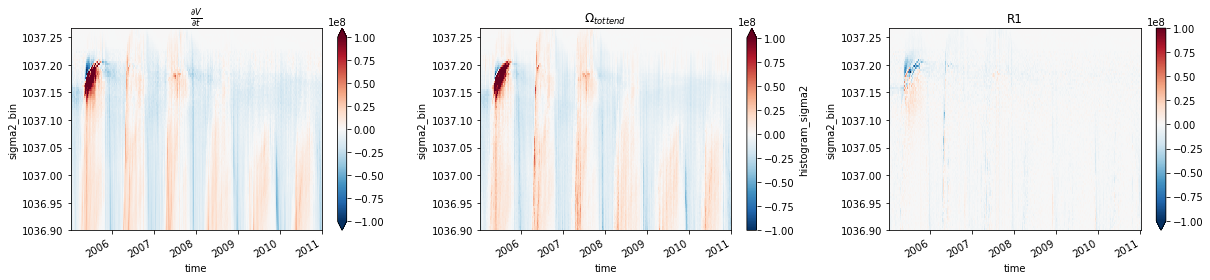

In [33]:
R1 = dVdt - omega_total

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

dVdt.plot(x='time', vmax=1e8, ax=ax0)
#ax0.set_ylim(ymax=1037.25, ymin=1035.5)
ax0.set_title(r'$\frac{\partial{V}}{\partial{t}}$')

omega_total.plot(x='time', vmax=1e8, ax=ax1)
#ax1.set_ylim(ymax=1037.25, ymin=1035.5)
ax1.set_title(r'$\Omega_{tottend}$')

R1.plot(x='time', vmax=1e8, ax=ax2)
#ax2.set_ylim(ymax=1037.25, ymin=1035.5)
ax2.set_title('R1')

plt.tight_layout();

In [68]:
plot_terms = np.array([[dVdt, omega_total, R1], [dVdt, omega_total_th, R1_th], [dVdt, omega_total_slt, R1_slt]])
plot_term_titles = np.array([[r'$\frac{\partial \mathcal{V}}{\partial t}$', 
                              '$\Omega$ (total_tendency)', 
                              r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Theta Component',
                              r'R1 Theta Component'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Salt Component',
                              r'R1 Salt Component']])

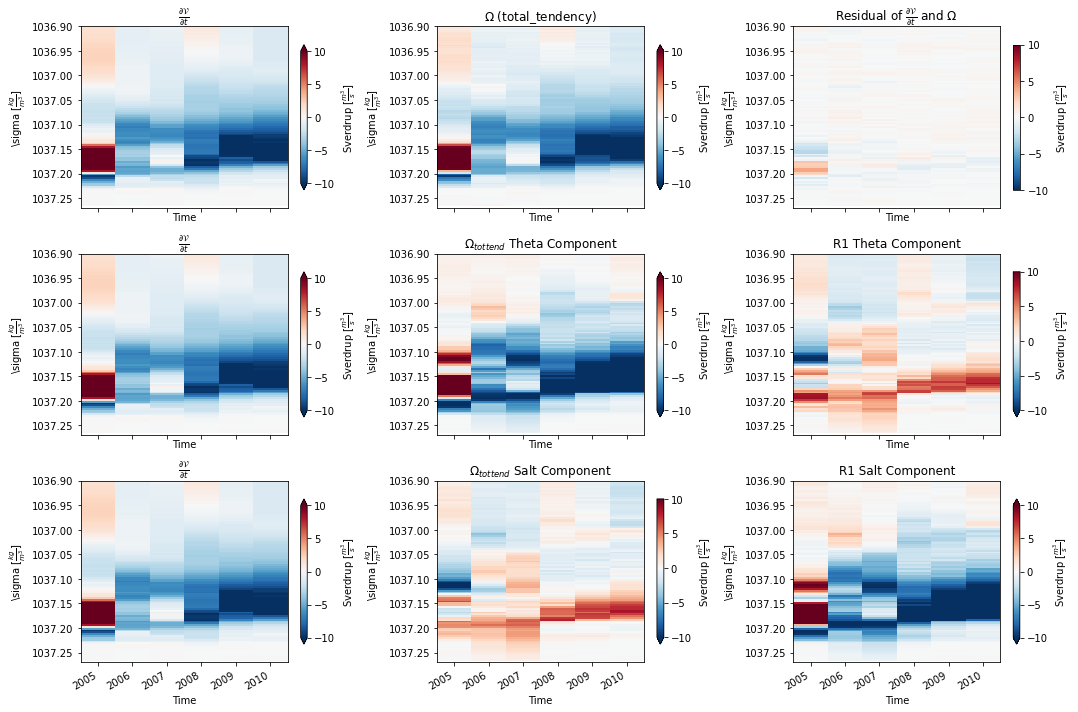

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

for i in range(0,3):
    for j in range(0,3): 
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        (term/1e6).resample(time='AS').mean(dim='time').plot(x='time', vmax=10, ax=axes[i,j],
                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
        axes[i,j].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
        axes[i,j].set_xlabel('Time')
        axes[i,j].set_title(title)
        axes[i,j].set_ylim(1037.27, 1036.9)
plt.tight_layout();

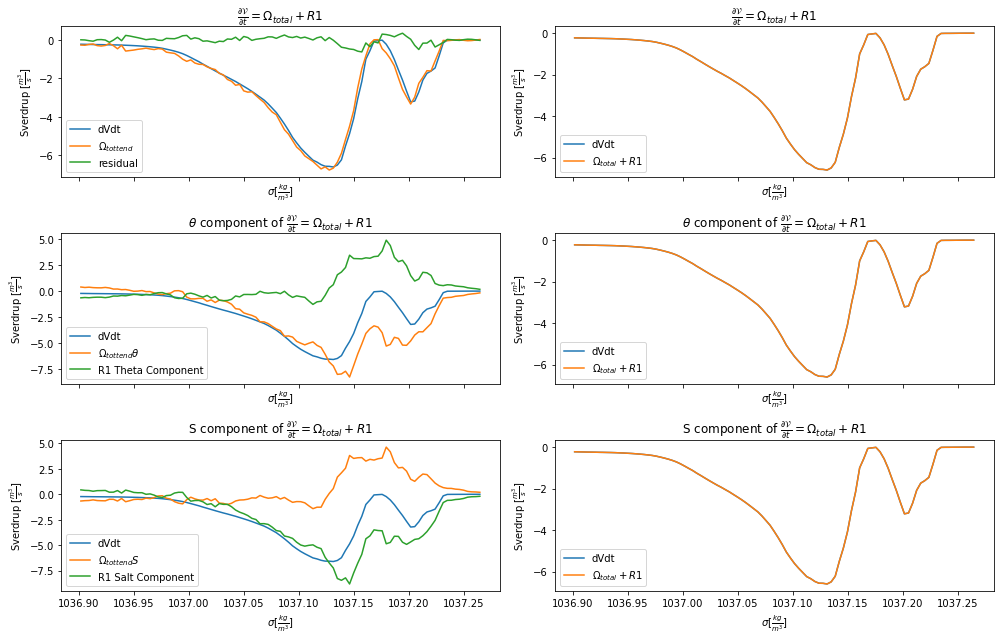

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[0,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[0,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
#axes[1,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[1,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,1].set_xlim(1035.5, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [71]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=variable.fillna(0.), dim=['XC', 'YC', 'Z'])
    return hist / (-delta_sigma)

In [72]:
all_tendencies_th = list(ds_sig_theta)
all_tendencies_slt = list(ds_sig_salt)

In [73]:
all_dsets_th = xr.merge([histogram_func(ds_sig_theta[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_th])
all_dsets_slt = xr.merge([histogram_func(ds_sig_salt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_slt])

In [74]:
all_dsets = xr.merge([all_dsets_th, all_dsets_slt])

In [75]:
all_dsets_slt

<xarray.Dataset>
Dimensions:                         (time: 438, sigma2_bin: 99)
Coordinates:
  * time                            (time) datetime64[ns] 2005-01-06 ... 2010...
  * sigma2_bin                      (sigma2_bin) float64 1.037e+03 ... 1.037e+03
Data variables:
    OMEGA_conv_horiz_adv_flux_SLT   (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SLT  (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_lin_fs_correction_SLT     (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_surface_flux_conv_SLT     (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 99), meta=np.ndarray>

In [76]:
omega_trans_rate_th = - (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                         all_dsets_th.OMEGA_conv_vert_diff_flux_TH +
                         all_dsets_th.OMEGA_lin_fs_correction_TH +
                         all_dsets_th.OMEGA_sw_flux_conv_TH + 
                         all_dsets_th.OMEGA_surface_flux_conv_TH)
omega_trans_rate_th.load()

omega_trans_rate_slt = - (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                          all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT +
                          all_dsets_slt.OMEGA_lin_fs_correction_SLT +
                          all_dsets_slt.OMEGA_surface_flux_conv_SLT)
omega_trans_rate_slt.load()

omega_trans_rate = omega_trans_rate_th + omega_trans_rate_slt
omega_trans_rate.load()

<xarray.DataArray (time: 438, sigma2_bin: 99)>
array([[ 48514336.,  68530400.,  77872456., ...,         0.,         0.,
                0.],
       [-21069258., -24839376., -22967588., ...,         0.,         0.,
                0.],
       [-26336684., -25835776., -28108444., ...,         0.,         0.,
                0.],
       ...,
       [-15968965., -14435888., -16432410., ...,         0.,         0.,
                0.],
       [ 69355576.,  54567608.,  68339088., ...,         0.,         0.,
                0.],
       [-47667580., -58985180., -66998600., ...,         0.,         0.,
                0.]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

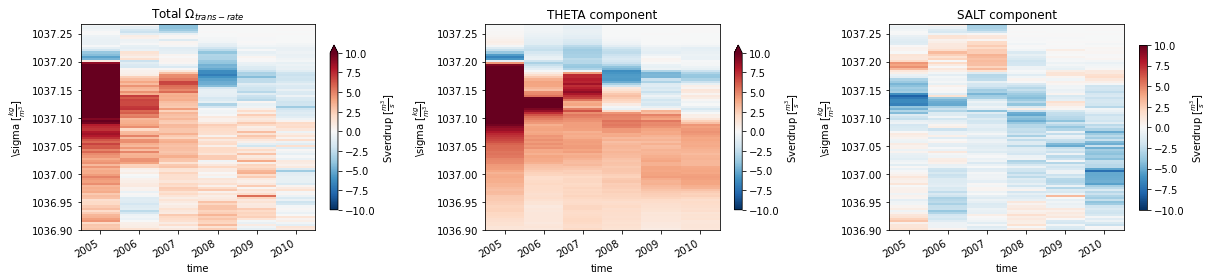

In [77]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_trans_rate_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_trans_rate_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [83]:
client.restart()

<Client: 'tls://10.8.13.14:8786' processes=2 threads=4, memory=8.00 GiB>

In [81]:
psi_adv_th = -(all_dsets_th.OMEGA_conv_horiz_adv_flux_TH + all_dsets_th.OMEGA_conv_vert_adv_flux_TH)
psi_adv_th.load()


In [82]:
psi_adv_slt = -(all_dsets_slt.OMEGA_conv_horiz_adv_flux_SLT + all_dsets_slt.OMEGA_conv_vert_adv_flux_SLT)
psi_adv_slt.load()

<xarray.DataArray (time: 438, sigma2_bin: 99)>
array([[-6.3227264e+07, -8.8467136e+07, -9.4782352e+07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.3459680e+06,  5.6405120e+06,  4.1520640e+06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.0058496e+07,  1.0338976e+07,  1.1998608e+07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.5092928e+07, -9.5358080e+06, -9.3021280e+06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.0192557e+08, -8.4051736e+07, -1.0236016e+08, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.9588512e+07,  4.0595328e+07,  4.7911808e+07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [84]:
psi_adv = psi_adv_th + psi_adv_slt
psi_adv.load()

<xarray.DataArray (time: 438, sigma2_bin: 99)>
array([[-6.45849840e+07, -9.01649440e+07, -9.44539280e+07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.72463150e+06,  4.98738500e+06,  3.96120350e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.67559100e+06,  9.49405900e+06,  8.93723700e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.23128140e+07, -1.11998350e+07, -9.00982600e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.03388024e+08, -8.61551120e+07, -1.03195384e+08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.05204280e+07,  3.99497040e+07,  4.83168600e+07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

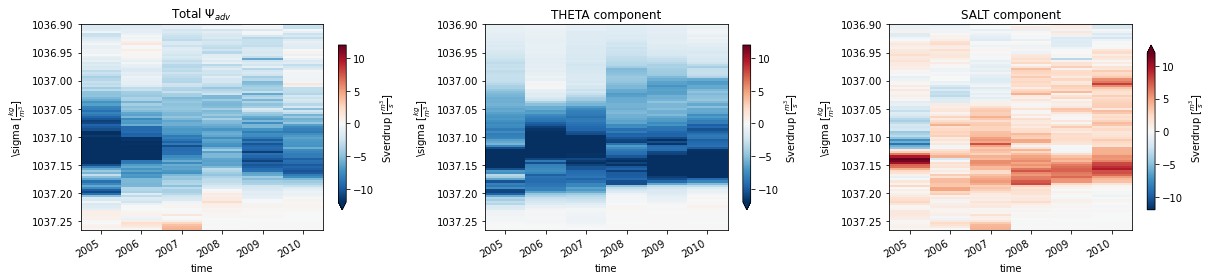

In [85]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(psi_adv.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=12, yincrease=False,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Psi_{adv}$')

(psi_adv_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=12, yincrease=False,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(psi_adv_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=12, yincrease=False,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## $\Psi_{vel}$

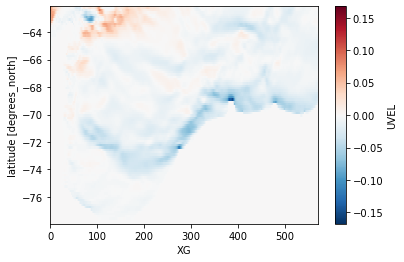

In [106]:
ds.UVEL.mean(dim=['time', 'Z']).drop('XG').plot()

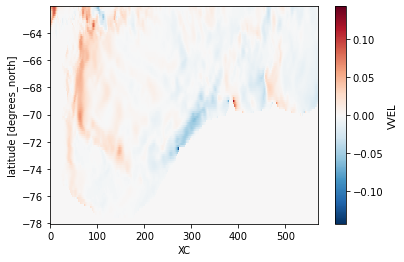

In [107]:
ds.VVEL.mean(dim=['time', 'Z']).drop('XC').plot()

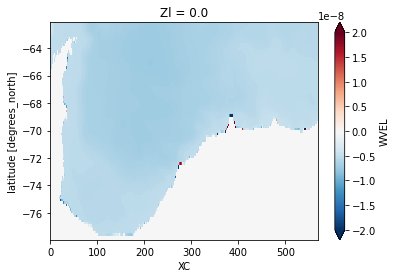

In [108]:
ds.WVEL.mean('time')[0].drop('XC').plot(vmax=0.2e-7)

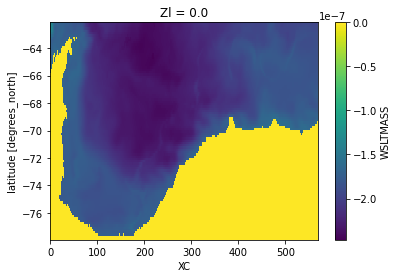

In [115]:
ds.WSLTMASS.mean('time')[0].drop('XC').plot()

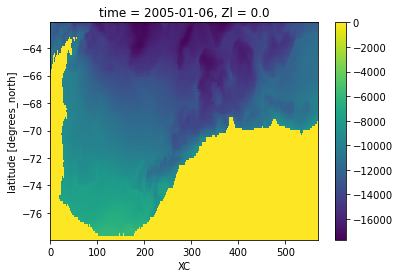

In [121]:
w_transport[0].drop('XC').plot()

In [24]:
ds.UVEL.coords

Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * XG       (XG) float32 295.0 295.2 295.3 295.5 ... 29.5 29.67 29.83 30.0

In [25]:
coords.dyG.coords

Coordinates:
  * XG       (XG) float32 295.0 295.2 295.3 295.5 ... 29.5 29.67 29.83 30.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21

In [27]:
coords.hFacW.coords

Coordinates:
  * XG       (XG) float32 295.0 295.2 295.3 295.5 ... 29.5 29.67 29.83 30.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03

In [86]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF * coords.hFacW).isel(XG=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF * coords.hFacW).isel(XG=0)

v_transport = (ds.VVEL * coords.dxG * coords.drF * coords.hFacS).isel(YG=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVEL.isel(Zl=0) * coords.rA

empmr_transport = (empmr.SIempmr/1034) * coords.rA #1034=rho

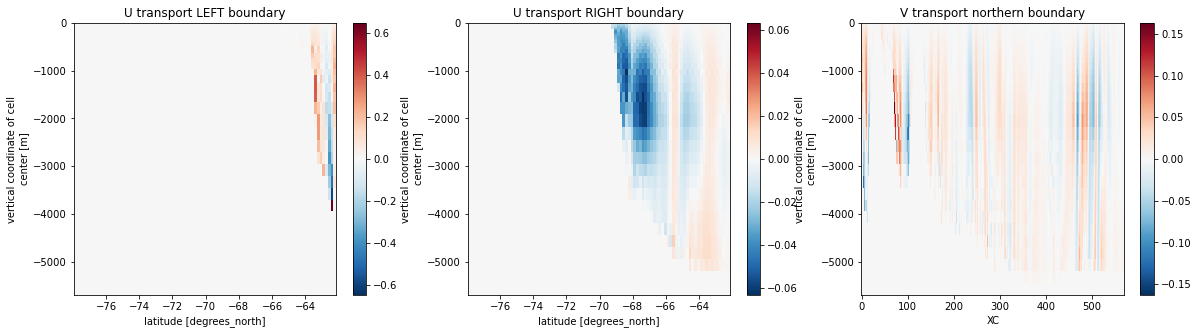

In [87]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=True, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=True, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).drop('XC').plot(yincrease=True, ax=ax2)
ax2.set_title('V transport northern boundary');

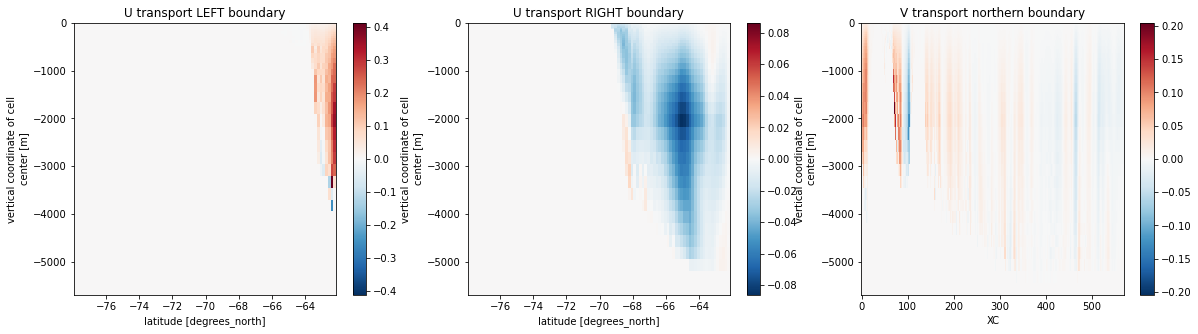

In [88]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left.mean(dim='time')/1e6).plot(yincrease=True, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right.mean(dim='time')/1e6).plot(yincrease=True, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport.mean(dim='time')/1e6).drop('XC').plot(yincrease=True, ax=ax2)
ax2.set_title('V transport northern boundary');

In [89]:
u_transport_right

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
dask.array<getitem, shape=(438, 42, 95), dtype=float32, chunksize=(1, 42, 95), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 30.0

In [90]:
u_transport_left

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
dask.array<getitem, shape=(438, 42, 95), dtype=float32, chunksize=(1, 42, 95), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 295.0

In [91]:
v_transport

<xarray.DataArray (time: 438, Z: 42, XC: 570)>
dask.array<getitem, shape=(438, 42, 570), dtype=float32, chunksize=(1, 42, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -62.12

In [92]:
u_transport_mean_value = (u_transport_right.sum(dim=['YC', 'Z']) -
                          u_transport_left.sum(dim=['YC', 'Z'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-45.081623, dtype=float32)

In [93]:
test = (u_transport_right - u_transport_left).mean(dim='time').sum()/1e6
test.load()

<xarray.DataArray ()>
array(-45.081623, dtype=float32)

In [94]:
v_transport_mean_value = (v_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(45.109535, dtype=float32)
Coordinates:
    YG       float32 -62.12

In [95]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.02791281, dtype=float32)
Coordinates:
    Zl       float32 0.0

In [96]:
residual = u_transport_mean_value + v_transport_mean_value #+ w_transport_mean_value + empmr_transport_mean_value
residual

<xarray.DataArray ()>
array(0.02791214, dtype=float32)
Coordinates:
    YG       float32 -62.12

In [97]:
# hack sigma to be on same grid pt as velocity components
sigma_at_u_right = sigma2.isel(XC=-1)
sigma_at_u_left = sigma2.isel(XC=0)
sigma_at_v = sigma2.isel(YC=-1)
sigma_at_w = sigma2.isel(Z=0)

In [98]:
sigma_at_u_right.load()

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
array([[[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.14223767, 1036.10883218, 1036.09016002],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.23989392, 1036.1981885 , 1036.17334421],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.75903364, 1036.75318125, 1036.74142829],
        ...,
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1037.21451077, 1037.21458475, 1037.21466233],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]],

       [[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.05790961, 1036.04839402, 1036.04733451],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.24822689, 1036.21136736, 1036.18501088],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.73631255, 1036.72438318, 1036.71026375],
...
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1037.21657109, 1037.2166451 , 1037.21660149],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]],

       [[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.57733219, 1036.55449939, 1036.54054124],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.68812119, 1036.68136664, 1036.68103651],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.83528633, 1036.81682016, 1036.81504335],
        ...,
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1037.21657933, 1037.21661758, 1037.21657039],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]]])
Coordinates:
    XC       float32 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [99]:
client.restart()

<Client: 'tls://10.8.13.14:8786' processes=30 threads=60, memory=120.00 GiB>

In [100]:
sigma_at_u_left.load()

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
array([[[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.05784705, 1036.03774545, 1036.01037389],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.06532942, 1036.04503511, 1036.01966398],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.29704635, 1036.2625943 , 1036.23335024],
        ...,
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]],

       [[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.06915969, 1036.06283143, 1036.05805728],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.07745997, 1036.07254069, 1036.06820523],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.24790613, 1036.23918344, 1036.22421134],
...
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]],

       [[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.06954294, 1036.06172363, 1036.06106256],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.08327538, 1036.0746925 , 1036.07318112],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1036.18085978, 1036.16816857, 1036.16296153],
        ...,
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]]])
Coordinates:
    XC       float32 295.1
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [101]:
client.restart()

<Client: 'tls://10.8.13.14:8786' processes=12 threads=24, memory=48.00 GiB>

In [102]:
sigma_at_v.load()

<xarray.DataArray (time: 438, Z: 42, XC: 570)>
array([[[1036.01037389, 1036.011094  , 1036.01048784, ...,
         1036.09182463, 1036.09097207, 1036.09016002],
        [1036.01966398, 1036.02151567, 1036.02288134, ...,
         1036.17419823, 1036.17379126, 1036.17334421],
        [1036.23335024, 1036.24785244, 1036.26337885, ...,
         1036.74048718, 1036.74119365, 1036.74142829],
        ...,
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1037.21470266, 1037.21468297, 1037.21466233],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]],

       [[1036.05805728, 1036.05777291, 1036.05600739, ...,
         1036.05017667, 1036.04874696, 1036.04733451],
        [1036.06820523, 1036.06820995, 1036.06736294, ...,
         1036.18622809, 1036.18577401, 1036.18501088],
        [1036.22421134, 1036.23304529, 1036.23910805, ...,
         1036.71159689, 1036.71118663, 1036.71026375],
...
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1037.21672715, 1037.21666804, 1037.21660149],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]],

       [[1036.06106256, 1036.06659287, 1036.07168576, ...,
         1036.54658356, 1036.54323383, 1036.54054124],
        [1036.07318112, 1036.07850151, 1036.0834003 , ...,
         1036.68708592, 1036.68334471, 1036.68103651],
        [1036.16296153, 1036.16490624, 1036.16354124, ...,
         1036.81361104, 1036.81381616, 1036.81504335],
        ...,
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1037.21669651, 1037.21663736, 1037.21657039],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989]]])
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    YC       float32 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [103]:
client.restart()

<Client: 'tls://10.8.13.14:8786' processes=0 threads=0, memory=0 B>

In [104]:
u_transport_right.load()

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -3.6375186e+02, -6.5288580e+02,  4.2363424e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -2.6480872e+02, -1.6018822e+02,  1.7776927e+02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -4.6306448e+02, -8.0652298e+01,  8.0926773e+01],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.6094484e+03,  8.7277405e+02,  2.7104719e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -2.2267429e+03, -1.8631833e+03, -1.7145078e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -1.0172824e+02, -3.1798825e+02,  3.9665125e+02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -3.4110565e+02, -2.1665181e+02,  3.9331714e+02],
...
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -1.3750824e+04, -3.5513910e+04, -4.6887562e+04],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -5.3503949e+02,  1.5963330e+03,  2.4100388e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -5.4858018e+03, -3.0620391e+03, -2.2692759e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -6.7682036e+03, -3.5540405e+03, -2.5086152e+03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          7.1136577e+03, -1.5438703e+04, -2.2879756e+04],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 30.0

In [105]:
u_transport_left.load()

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
array([[[     0.     ,      0.     ,      0.     , ...,   7469.4766 ,
          26079.223  ,  37609.203  ],
        [     0.     ,      0.     ,      0.     , ...,   2254.7817 ,
          22940.617  ,  35989.8    ],
        [     0.     ,      0.     ,      0.     , ...,   1080.9448 ,
          23901.594  ,  38285.84   ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[     0.     ,      0.     ,      0.     , ..., -13133.107  ,
           1389.9474 ,  26117.266  ],
        [     0.     ,      0.     ,      0.     , ..., -13725.733  ,
           2354.1047 ,  29478.078  ],
        [     0.     ,      0.     ,      0.     , ..., -16345.793  ,
           1120.3207 ,  30882.182  ],
...
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[     0.     ,      0.     ,      0.     , ...,  27437.627  ,
          15903.638  ,   6064.967  ],
        [     0.     ,      0.     ,      0.     , ...,  26734.441  ,
          13491.149  ,   1913.8492 ],
        [     0.     ,      0.     ,      0.     , ...,  25929.238  ,
          12004.949  ,   -806.1666 ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]]], dtype=float32)
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 295.0

In [106]:
v_transport.load()

<xarray.DataArray (time: 438, Z: 42, XC: 570)>
array([[[ 10006.59   ,   9114.26   ,   7924.1064 , ...,    316.67834,
            234.7969 ,    131.806  ],
        [ 10893.124  ,   9892.3545 ,   8577.128  , ...,   -598.91223,
           -643.9089 ,   -709.25256],
        [ 10798.21   ,   9733.189  ,   8312.6    , ...,   -523.11084,
           -577.75055,   -653.0387 ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,   4857.175  ,
           4997.6978 ,   5033.644  ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[ 10423.91   ,   7526.055  ,   3854.657  , ...,    956.0308 ,
            913.7638 ,    848.6734 ],
        [ 12577.611  ,   9324.325  ,   5219.632  , ...,   -689.5311 ,
           -741.5303 ,   -815.3844 ],
        [ 13949.471  ,  10418.797  ,   5921.233  , ...,   -720.6549 ,
           -778.31445,   -851.73755],
...
        [     0.     ,      0.     ,      0.     , ..., -10385.071  ,
         -10193.488  ,  -9397.439  ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[  2815.8125 ,   2725.256  ,   4550.1426 , ...,  -3643.791  ,
          -3857.3337 ,  -3976.6338 ],
        [  4627.1904 ,   4552.1353 ,   6652.0107 , ...,  -1384.6714 ,
          -1587.5623 ,  -1701.6239 ],
        [  4221.2334 ,   4216.95   ,   6551.086  , ...,  -1585.3152 ,
          -1836.8367 ,  -1977.8396 ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,  -8085.4067 ,
          -7977.688  ,  -7271.7827 ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -62.12

In [107]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right, dim=['Z', 'YC'])

In [108]:
u_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left, dim=['Z', 'YC'])

In [109]:
v_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport, dim=['Z', 'XC'])

# Potential Bug: two u_binned, putting into one big computation - dask getting confused as to which u was which.

In [110]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 99)>
array([[       -0.        ,        -0.        ,        -0.        , ...,
        -13411899.66586003, -13501309.4468182 , -13462521.46836743],
       [       -0.        ,        -0.        ,        -0.        , ...,
          1949934.81276876,   1747801.60261708,   2054293.55150777],
       [       -0.        ,        -0.        ,        -0.        , ...,
           770079.84335369,    791341.11566204,    730617.43016857],
       ...,
       [       -0.        ,        -0.        ,        -0.        , ...,
          2090318.99504215,   2185354.73741275,   2278165.02831203],
       [       -0.        ,        -0.        ,        -0.        , ...,
          -467137.52566344,   -397376.11300474,   -368629.25687987],
       [       -0.        ,        -0.        ,        -0.        , ...,
          -360495.76497513,   -235292.27722031,   -414262.27959305]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

Text(0.5, 1.0, '$\\Psi_{vel}$')

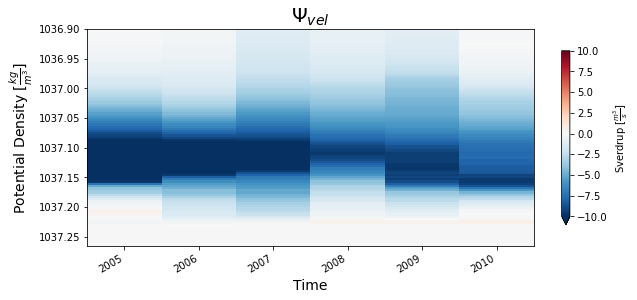

In [112]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
#plt.ylim(1037.3, 1035.5);

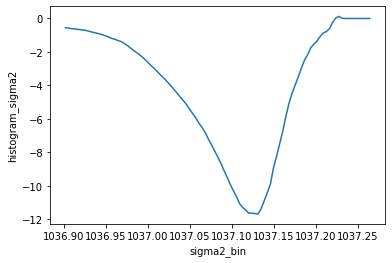

In [113]:
(psi_vel/1e6).mean(dim='time').plot()
#plt.xlim(1035.5, 1037.3)

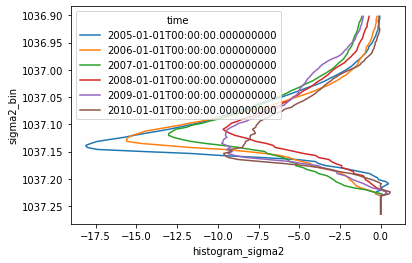

In [115]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin', add_legend=True, yincrease=False)
#plt.ylim(1037.3, 1035.5);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [116]:
R2 = (psi_adv - psi_vel).load()
R2_th = (psi_adv_th - psi_vel).load()
R2_slt = (psi_adv_slt - psi_vel).load()

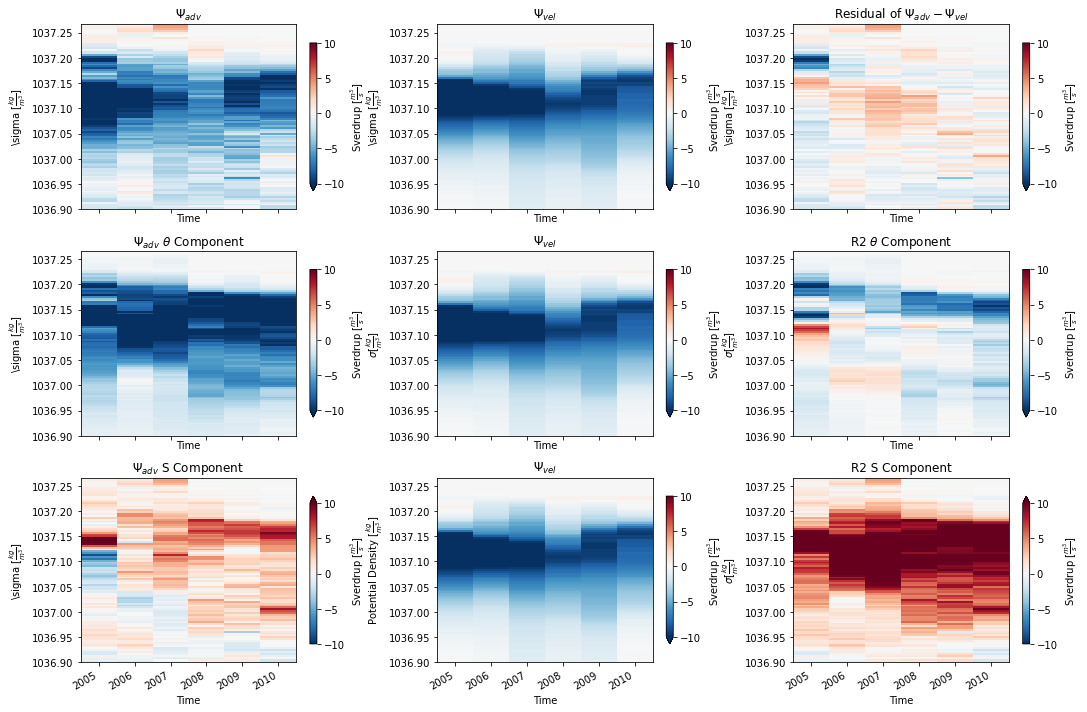

In [117]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,0].set_xlabel('Time')
axes[0,0].set_title(r'$\Psi_{adv}$')
#axes[0,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')
axes[0,1].set_title('$\Psi_{vel}$')
#axes[0,1].set_ylim(1037.3, 1035.5)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$')
#axes[0,2].set_ylim(1037.3, 1035.5)

(psi_adv_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\Psi_{adv}$ $\theta$ Component')
#axes[1,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title('$\Psi_{vel}$')
#axes[1,1].set_ylim(1037.3, 1035.5)

(R2_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')
axes[1,2].set_title(r'R2 $\theta$ Component')
#axes[1,2].set_ylim(1037.3, 1035.5)

(psi_adv_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\Psi_{adv}$ S Component')
#axes[2,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title('$\Psi_{vel}$')
#axes[2,1].set_ylim(1037.3, 1035.5)

(R2_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R2 S Component')
#axes[2,2].set_ylim(1037.3, 1035.5)

plt.tight_layout();

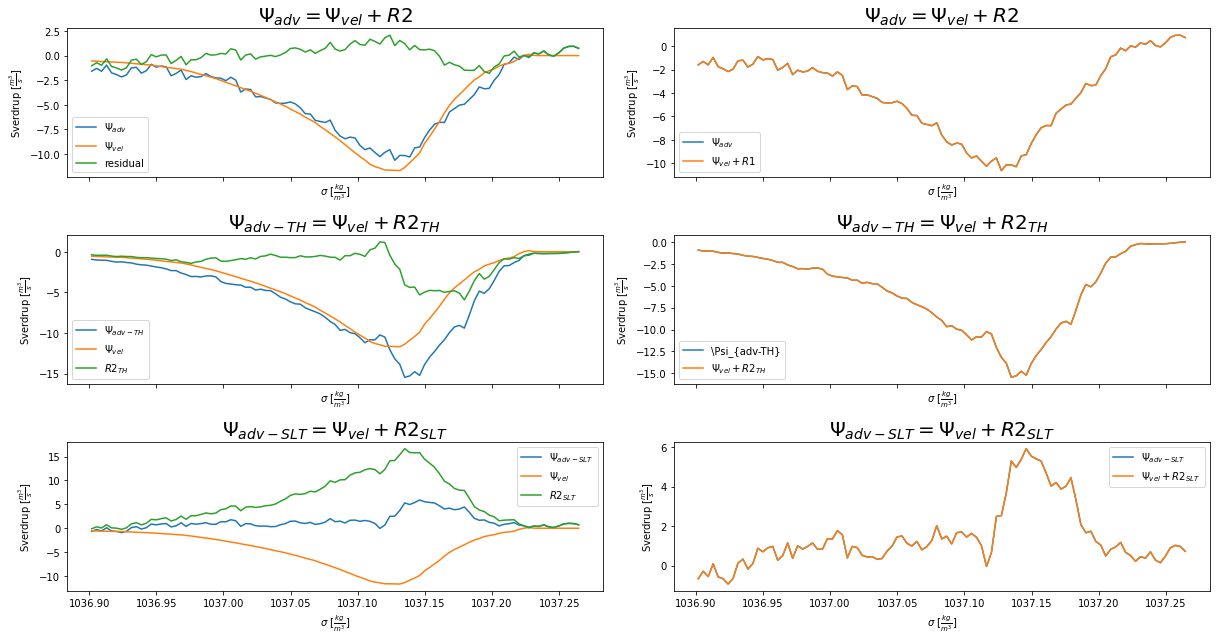

In [118]:
fig, axes = plt.subplots(3, 2, figsize=(17, 9), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,0].set_xlim(1037.3, 1035.5)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,1])
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,1].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-TH}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{TH}$', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$ ', fontsize=20)
#axes[1,0].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label='\Psi_{adv-TH}', ax=axes[1,1])
((psi_vel + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{TH}$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$', fontsize=20)
#axes[1,1].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_{SLT}$', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
#axes[2,0].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,1])
((psi_vel + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{SLT}$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
#axes[2,1].set_xlim(1037.3, 1035.5)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>

In [119]:
R3_th = omega_total_th - (psi_adv_th + omega_trans_rate_th)
R3_th.load()
R3_slt = omega_total_slt - (psi_adv_slt + omega_trans_rate_slt)
R3_slt.load()
R3 = omega_total - (psi_adv + omega_trans_rate)
R3.load()

<xarray.DataArray (time: 438, sigma2_bin: 99)>
array([[-248.41538993,  -72.76790782, -415.06821582, ...,    0.        ,
           0.        ,    0.        ],
       [-177.96359259, -207.75741958,  315.34254972, ...,    0.        ,
           0.        ,    0.        ],
       [-229.49217936,  168.35456031,  -31.03389725, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [ -21.88359488,  -44.06265767,  -72.85661236, ...,    0.        ,
           0.        ,    0.        ],
       [ 285.49173551,  281.65366656, -233.84622905, ...,    0.        ,
           0.        ,    0.        ],
       [ 196.44887828,  -64.69165179, -461.53030717, ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

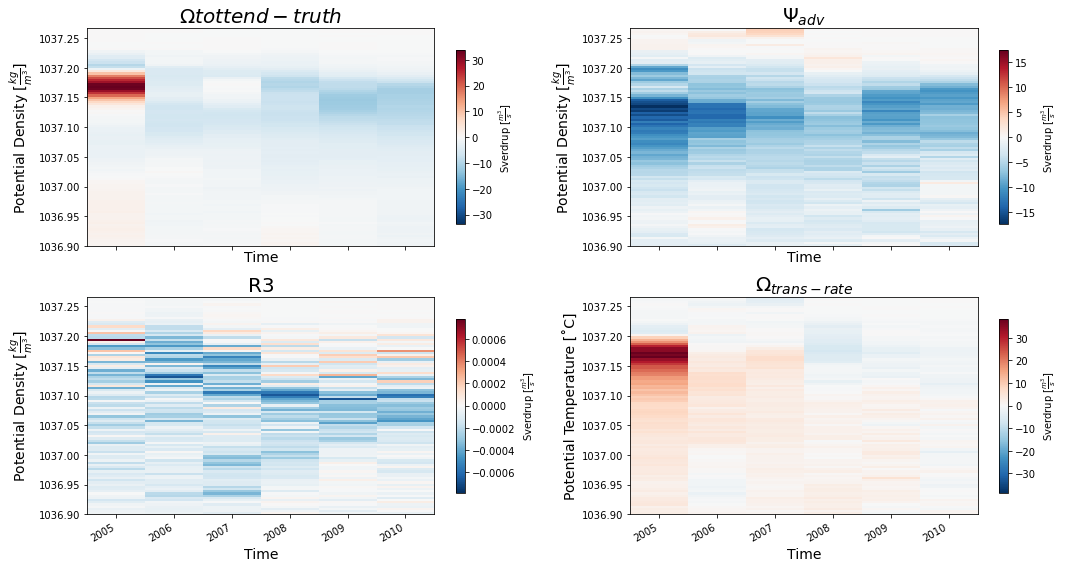

In [120]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,0],
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega{tottend-truth}$', fontsize=20)
#ax[0,0].set_ylim(1036.4, 1037.3)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('$\Psi_{adv}$', fontsize=20)
#ax[0,1].set_ylim(1036.4, 1037.3)

(R3/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,0], 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'R3', fontsize=20)
#ax[1,0].set_ylim(1036.4, 1037.3)

(omega_trans_rate/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,1].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('$\Omega_{trans-rate}$', fontsize=20)
#ax[1,1].set_ylim(1036.4, 1037.3)

plt.tight_layout();

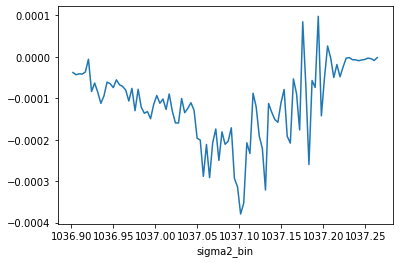

In [121]:
(R3/1e6).mean(dim='time').plot()
#plt.xlim(1035, 1038)

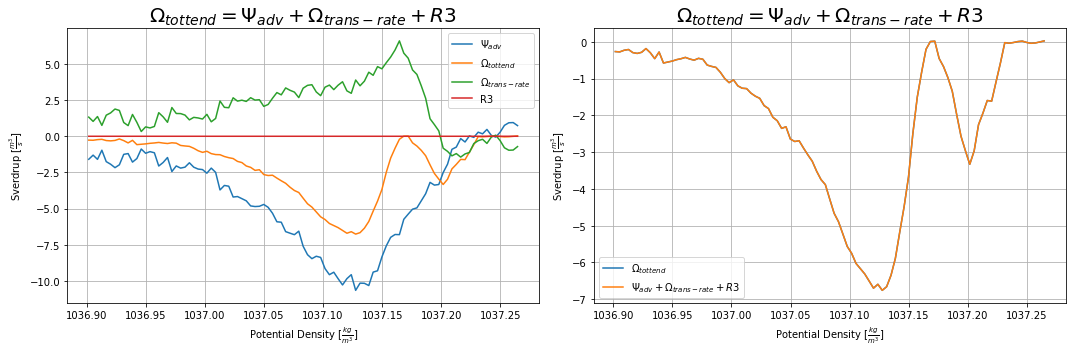

In [122]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.grid()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
#ax0.set_xlim(1036.4, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax1)
((psi_adv + omega_trans_rate + R3)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.grid()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
#ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

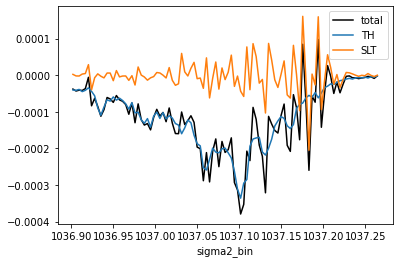

In [123]:
(R3/1e6).mean(dim='time').plot(color='k', label='total')
(R3_th/1e6).mean(dim='time').plot(label='TH')
(R3_slt/1e6).mean(dim='time').plot(label='SLT')
plt.legend()
#plt.xlim(1037.5, 1036.5)

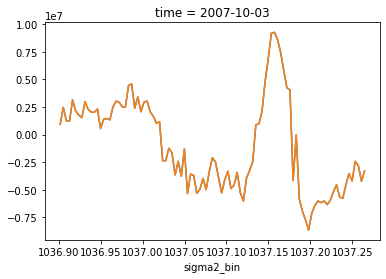

In [124]:
n = 200
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv).isel(time=n).plot()

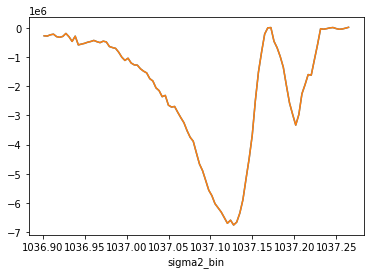

In [125]:
omega_total.mean(dim='time').plot()
(omega_trans_rate + psi_adv).mean(dim='time').plot()
#plt.xlim(1036.4, 1037.3);

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1 \end{equation*} </font>

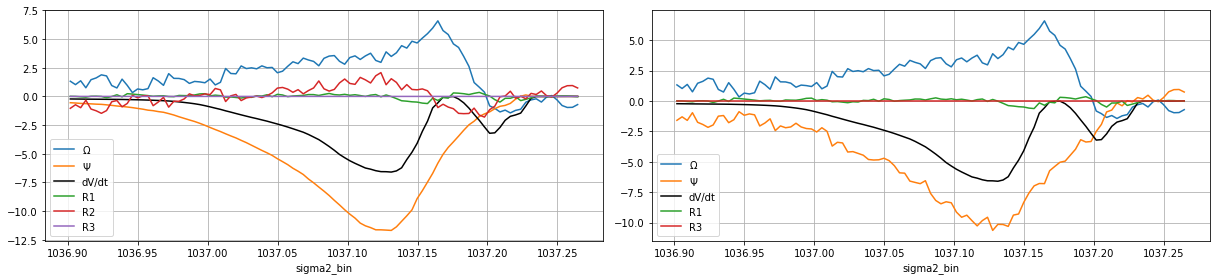

In [126]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax1)
(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax1)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax1)
ax1.legend()
ax1.grid()
#ax1.set_xlim(1036.4, 1037.3)
plt.tight_layout();

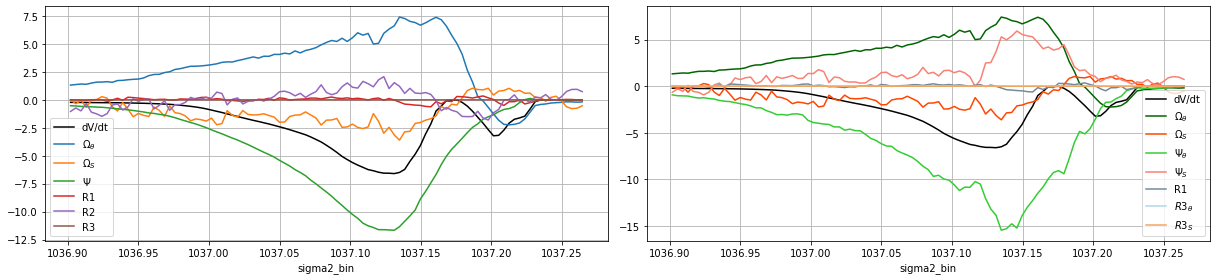

In [127]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax0)
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax1, color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax1, color='orangered')
(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{\theta}$', ax=ax1, color='limegreen')
(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_S$', ax=ax1, color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R3_th/1e6).mean(dim='time').plot(label=r'$R3_{\theta}$', ax=ax1, color='lightblue')
(R3_slt/1e6).mean(dim='time').plot(label=r'$R3_S$', ax=ax1, color='sandybrown')
ax1.legend()
ax1.grid()
#ax1.set_xlim(1036.4, 1037.3)
plt.tight_layout();

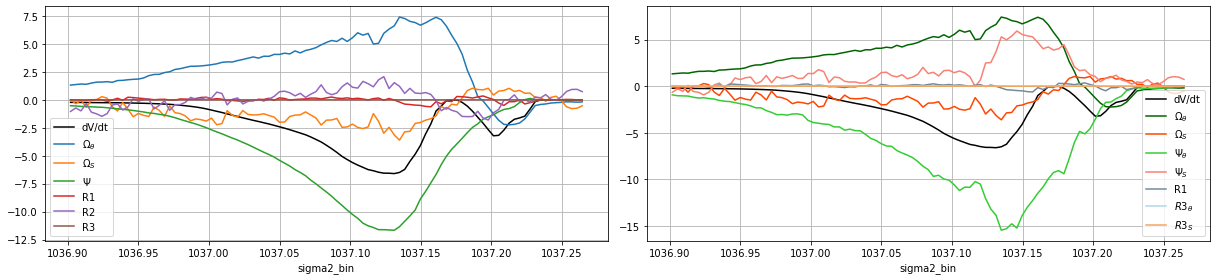

In [128]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax0)
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax1, color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax1, color='orangered')
(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{\theta}$', ax=ax1, color='limegreen')
(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_S$', ax=ax1, color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R3_th/1e6).mean(dim='time').plot(label=r'$R3_{\theta}$', ax=ax1, color='lightblue')
(R3_slt/1e6).mean(dim='time').plot(label=r'$R3_S$', ax=ax1, color='sandybrown')
ax1.legend()
ax1.grid()
#ax1.set_xlim(1035.5, 1037.3)
plt.tight_layout();

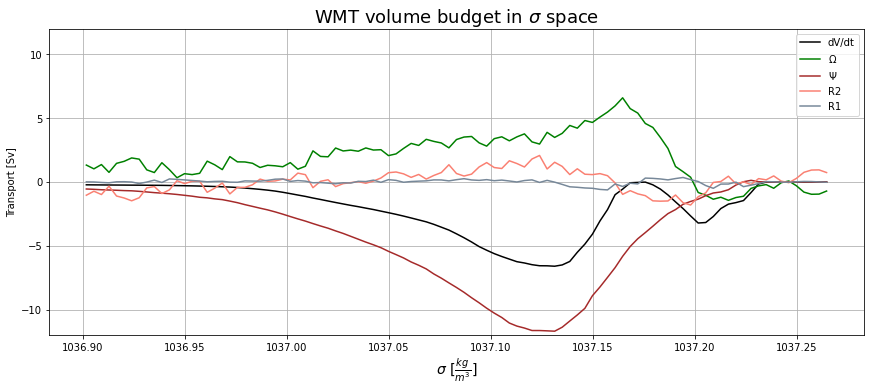

In [129]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.3)
plt.ylim(-12, 12)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);

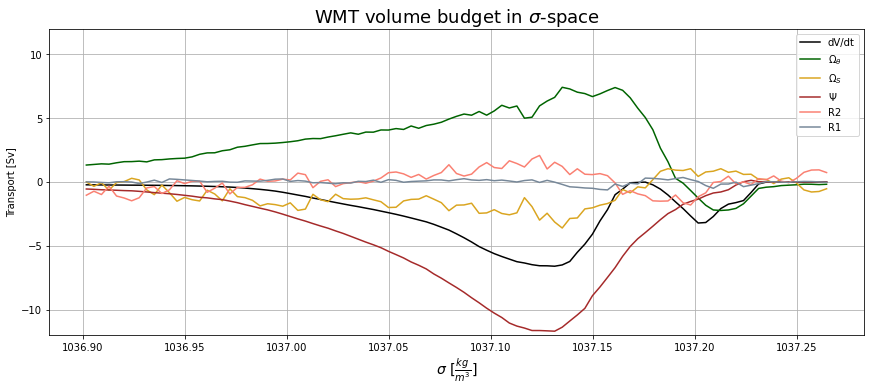

In [130]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-12, 12)
#plt.xlim(1035.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$-space', fontsize=18);

In [132]:
import pandas as pd

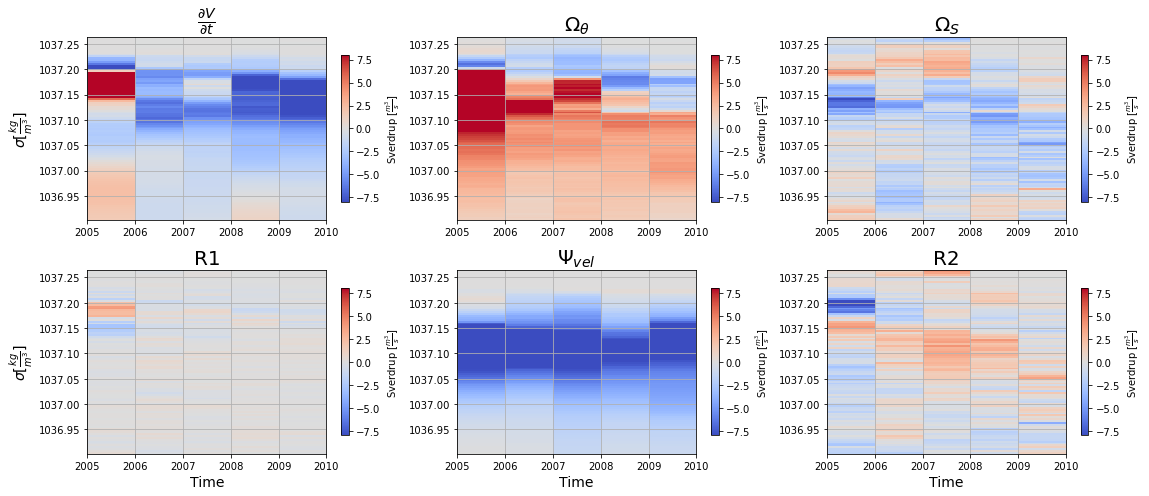

In [133]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))#, sharex=True)

dVdt_resampled = dVdt.resample(time='AS').mean(dim='time') / 1e6
c = ax[0,0].pcolormesh(pd.to_datetime(dVdt_resampled.time), 
                   dVdt_resampled.sigma2_bin, 
                   dVdt_resampled.T, vmin=-8, vmax=8, cmap='coolwarm')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

omega_th_resampled = (omega_trans_rate_th/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,1].pcolormesh(pd.to_datetime(omega_th_resampled.time), omega_th_resampled.sigma2_bin, omega_th_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c0, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Omega_{\theta}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

omega_slt_resampled = (omega_trans_rate_slt/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,2].pcolormesh(pd.to_datetime(omega_slt_resampled.time), omega_slt_resampled.sigma2_bin, omega_slt_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,2])
#ax[0,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,2].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega_{S}$', fontsize=20)
#ax[0,2].set_ylim(1037.3, 1036.3)
ax[0,2].grid()

R1_resampled = (R1/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(pd.to_datetime(R1_resampled.time), R1_resampled.sigma2_bin, R1_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('R1', fontsize=20)
#ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

psi_vel_resampled = (psi_vel/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(pd.to_datetime(psi_vel_resampled.time), psi_vel_resampled.sigma2_bin, psi_vel_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()

R2_resampled = (R2/1e6).resample(time='AS').mean(dim='time')
c4 = ax[1,2].pcolormesh(pd.to_datetime(R2_resampled.time), R2_resampled.sigma2_bin, R2_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c4, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title('R2', fontsize=20)
#ax[1,2].set_ylim(1037.3, 1036.3)
ax[1,2].grid()
plt.tight_layout();

In [134]:
dVdt_resampled = dVdt.resample(time='AS').mean(dim='time') / 1e6

Text(0.5, 1.0, '$\\frac{\\partial V}{\\partial t}$')

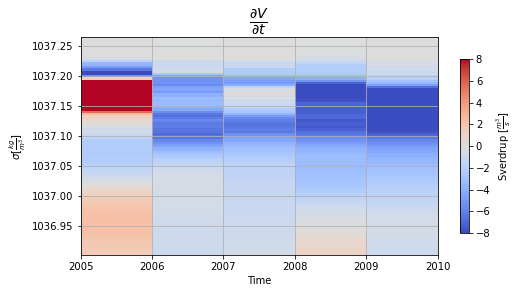

In [137]:
plt.figure(figsize=(8,4))
c = plt.pcolormesh(pd.to_datetime(dVdt_resampled.time), 
                   dVdt_resampled.sigma2_bin, 
                   dVdt_resampled.T, vmin=-8, vmax=8, cmap='coolwarm')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$')
plt.grid()
plt.ylabel(r'$\sigma [\frac{kg}{m^3}]$')
plt.xlabel('Time')
plt.title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#plt.ylim(1037.3, 1036.3);

In [86]:
dVdt_resampled.differentiate(coord='sigma2_bin')

<xarray.DataArray (time: 6, sigma2_bin: 199)>
array([[-1.15288061e-17, -4.48342459e-18,  3.84293536e-18, ...,
         2.73435359e-01,  2.14796155e-01,  1.92895003e-01],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.35575783e-02, -5.72121076e-02, -5.68341212e-02],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.27508938e-02,  6.64632528e-02,  5.83934433e-02],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.61111471e-01,  1.61234804e-01,  1.63742123e-01],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.08924810e-03, -1.97557382e-03, -1.72273161e-04],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.33224901e-03, -6.02460254e-03, -1.05405962e-02]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-01 2006-01-01 ... 2010-01-01
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

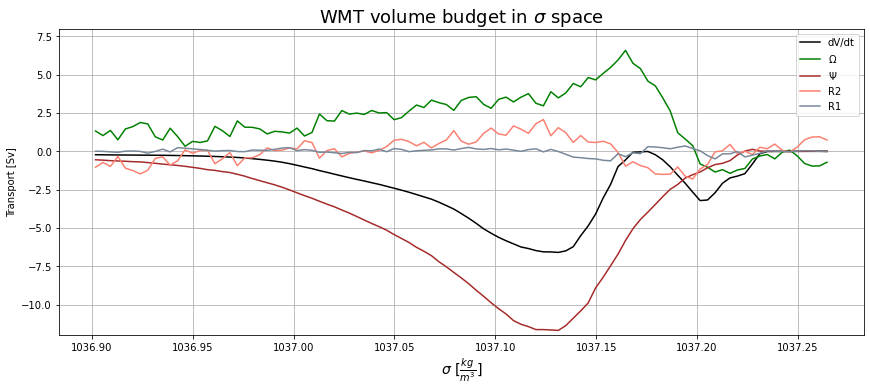

In [138]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.xlim(1036.5, 1037.3)
plt.ylim(-12, 8)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);

ValueError: Could not convert object to NumPy datetime

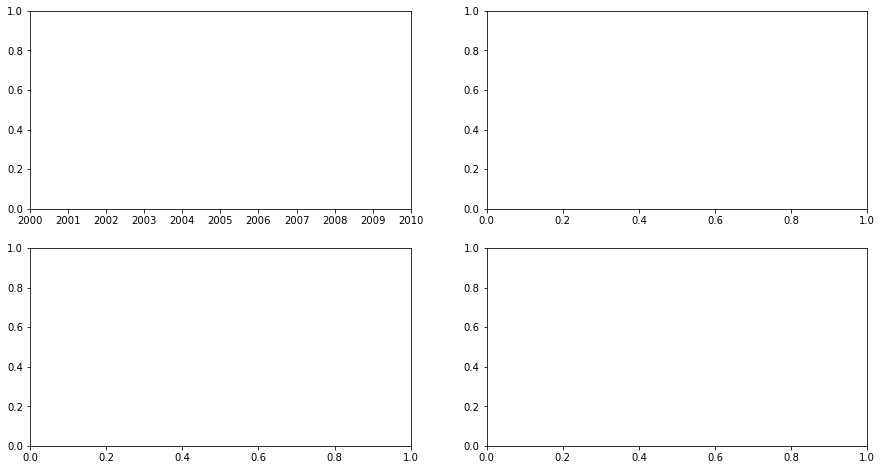

In [139]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))#, sharex=True)

omega_resampled = (omega_trans_rate/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,0].pcolormesh(omega_resampled.time, omega_resampled.sigma2_bin, omega_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega$', fontsize=20)
#ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

psi_vel_resampled = (psi_vel/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,1].pcolormesh(psi_vel_resampled.time, psi_vel_resampled.sigma2_bin, psi_vel_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

R1_resampled = (R1/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(R1_resampled.time, R1_resampled.sigma2_bin, R1_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('R1', fontsize=20)
#ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

R2_resampled = (R2/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(R2_resampled.time, R2_resampled.sigma2_bin, R2_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('R2', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()
plt.tight_layout();

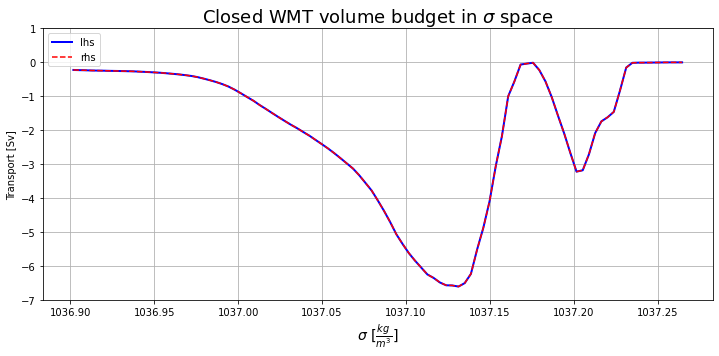

In [140]:
(dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Closed WMT volume budget in $\sigma$ space', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
plt.ylim(-7,1);
#plt.xlim(1035.5, 1037.3);

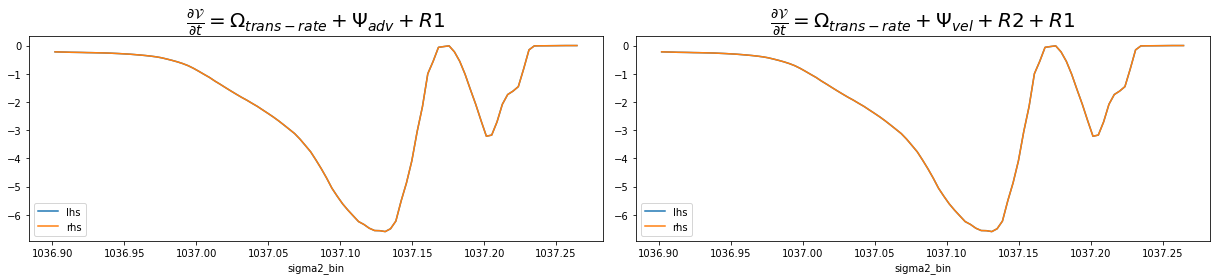

In [141]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
ax0.legend()
#ax0.set_xlim(1036.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{vel} + R2 + R1$', fontsize=20, fontweight='bold')
ax1.legend()
#ax1.set_xlim(1036.5, 1037.3)

plt.tight_layout();

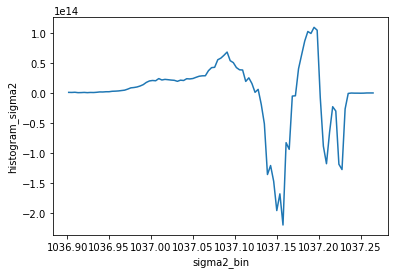

In [142]:
(sigma_dist[-1] - sigma_dist[0]).plot()
#plt.xlim(1036.5, 1037.3);

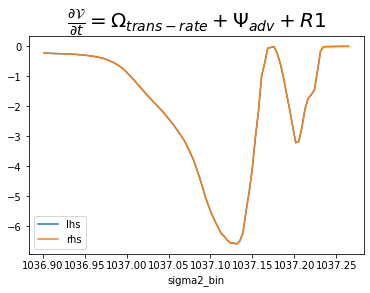

In [143]:
(dVdt/1e6).mean(dim='time').plot(label='lhs') 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(label='rhs')
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
plt.legend()
#plt.xlim(1036.5, 1037.3)

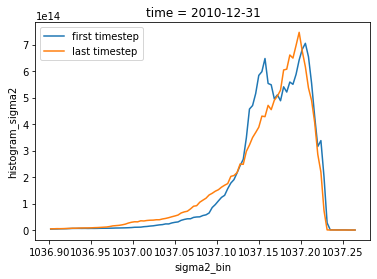

In [144]:
#waters with density up to 1037.13 got denser?
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1036.7, 1037.3);

#### Need to redescribe after changing sigma bin range and size

- 1037.0-1037.15: volume is added (3rd plot), positive lobe meaning volume is increasing (1st plot), negative slope meaning (waters up to 1037.1) the rate of cumulative volume distribution is decreasing so therefore, more water buildup of waters in this range bc of less distribution of the waters (that’s why you see more volume in “last timestep” and positive lobe in 1st plot). 

- 1037.15-1037.18: volume is lost (3rd plot), negative lobe meaning volume is decreasing (1st plot), positive slope meaning increased volume distribution meaning waters in this range are being distributed at a higher rate (that’s why you see less volume in “last timestep” and negative lobe in 1st plot).

- 1037.18-1027.2: There is more water within this range at last time step, another positive lobe meaning volume is added (1st plot), negative slope in 2nd plot meaning rate of redistribution is decreasing.

## Breaking up $\Omega_{trans-rate}$ term

In [145]:
all_dsets_slt

<xarray.Dataset>
Dimensions:                         (time: 438, sigma2_bin: 99)
Coordinates:
  * time                            (time) datetime64[ns] 2005-01-06 ... 2010...
  * sigma2_bin                      (sigma2_bin) float64 1.037e+03 ... 1.037e+03
Data variables:
    OMEGA_conv_horiz_adv_flux_SLT   (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SLT  (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_lin_fs_correction_SLT     (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_surface_flux_conv_SLT     (time, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 99), meta=np.ndarray>

In [150]:
client.restart()

<Client: 'tls://10.8.13.14:8786' processes=18 threads=36, memory=72.00 GiB>

In [147]:
omega_mix_th = (- (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                  all_dsets_th.OMEGA_conv_vert_diff_flux_TH)).load()

In [147]:
omega_surf_th = (-(all_dsets_th.OMEGA_sw_flux_conv_TH + 
                  all_dsets_th.OMEGA_surface_flux_conv_TH)).load()

In [149]:
omega_mix_slt = (- (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                   all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT)).load()

In [151]:
omega_surf_slt = (- all_dsets_slt.OMEGA_surface_flux_conv_SLT).load()

In [152]:
omega_surf = (omega_surf_th + omega_surf_slt).load()

In [153]:
omega_mix = (omega_mix_th + omega_mix_slt).load()

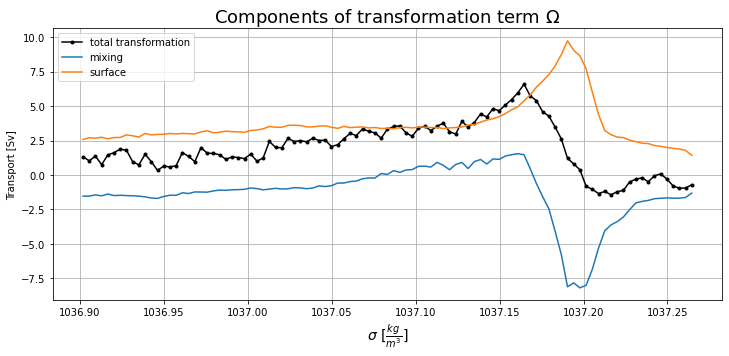

In [155]:
(omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k', marker='.')
(omega_mix/1e6).mean(dim='time').plot(label='mixing')
(omega_surf/1e6).mean(dim='time').plot(label='surface')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Components of transformation term $\Omega$', fontsize=18);

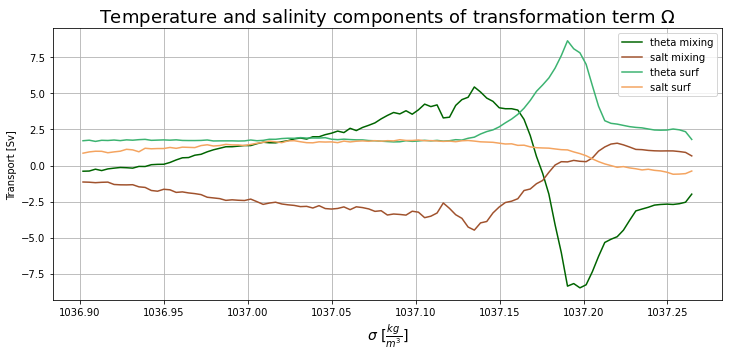

In [156]:
(omega_mix_th/1e6).mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(omega_mix_slt/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(omega_surf_th/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(omega_surf_slt/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Temperature and salinity components of transformation term $\Omega$', fontsize=18);

## Saving WMT budget terms to netcdf

In [157]:
dVdt.coords

Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [158]:
omega_total.coords

Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [159]:
R2.coords

Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [160]:
psi_adv.coords

Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [161]:
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), R1.rename('R1'),
                             R1_th.rename('R1_th'), R1_slt.rename('R1_slt'),
                             omega_total.rename('omega_total'),
                             omega_total_th.rename('omega_total_th'),
                             omega_total_slt.rename('omega_total_slt'),
                             psi_adv.rename('psi_adv'),
                             psi_vel.rename('psi_vel'), R2.rename('R2'),
                             R2_th.rename('R2_th'), R2_slt.rename('R2_slt'),
                             omega_trans_rate.rename('omega_trans_rate'),
                             omega_trans_rate_th.rename('omega_trans_rate_th'),
                             omega_trans_rate_slt.rename('omega_trans_rate_slt'),
                             omega_surf.rename('omega_surf'),
                             omega_surf_slt.rename('omega_surf_slt'),
                             omega_surf_th.rename('omega_surf_th'), 
                             omega_mix.rename('omega_mix'), 
                             omega_mix_th.rename('omega_mix_th'),
                             omega_mix_slt.rename('omega_mix_slt'),
                             R3.rename('R3'), R3_th.rename('R3_th'), R3_slt.rename('R3_slt')])

In [34]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [35]:
omega_total = omega_total.to_dataset(name='omega_total')

In [36]:
omega_total

<xarray.Dataset>
Dimensions:      (time: 437, sigma2_bin: 99)
Coordinates:
  * time         (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin   (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
Data variables:
    omega_total  (time, sigma2_bin) float64 -1.64e+07 -1.702e+07 ... 0.0 0.0

In [37]:
#uploading new omega_total with totend being dsigma2/dt
gcsmap_omega_total = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/omega_total_newbins.zarr')
omega_total.to_zarr(gcsmap_omega_total, mode='w')

In [38]:
#uploading new R1 with omega_total being new totend
R1 = R1.to_dataset(name='R1')

In [ ]:
gcsmap_R1 = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/R1_newbins.zarr')
R1.to_zarr(gcsmap_R1, mode='w')

In [113]:
# uploading to cloud instead of here bc I can't `to_netcdf` w workers on
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

In [163]:
# uploading to cloud instead of here bc I can't `to_netcdf` w workers on
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms_newbins.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

In [117]:
sigma2 = sigma2.rename('sigma2').to_dataset()

In [119]:
# saving sigma2 
gcsmap_sigma2 = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/sigma2.zarr')
sigma2.to_zarr(gcsmap_sigma2, mode='w')

In [122]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (sigma2_bin: 999, time: 438)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    R1                    (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R2                    (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_slt                (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_th                 (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R3                    (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R3_slt                (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R3_th                 (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    omega_mix             (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_slt         (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_th          (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf            (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_slt        (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_th         (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_total           (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_total_slt       (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_total_th        (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate      (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate_slt  (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate_th   (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv               (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel               (time, sigma2_bin) float64 -1.318e+07 ... -0.0

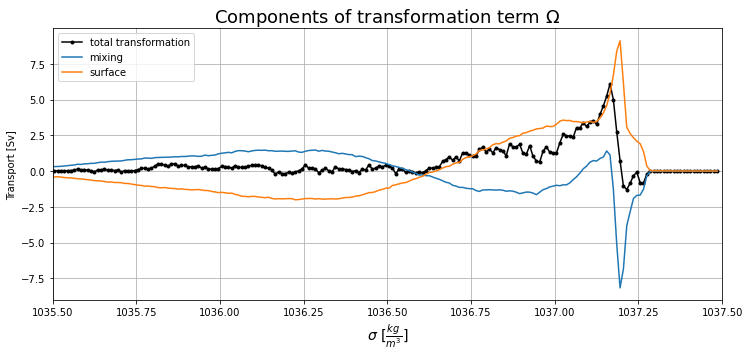

In [123]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k', marker='.')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label='mixing')
(wmt_budget_terms.omega_surf/1e6).mean(dim='time').plot(label='surface')
plt.legend()
plt.grid()
plt.xlim(1035.5, 1037.5)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Components of transformation term $\Omega$', fontsize=18);